In [1]:
import os

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Social_Media_Analysis/final presentation') #切換該目錄
os.listdir() #確認目錄內容

Mounted at /content/drive


['dict', 'data', 'ai_topic_to_topic_model.ipynb']

In [2]:
import time
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

from nltk import ngrams, FreqDist
!pip install tqdm
from tqdm import tqdm
# 啟用 tqdm 進度條顯示
tqdm.pandas()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.8 MB/s eta 0:00:00


In [3]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# 設定中文字體
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 資料前處理

In [5]:
df = pd.read_csv("./data/ptt_ai_221130to240531.csv")  # 匯資料
df.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,ggglu,Finance,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""cow38"", ""cmt...",118.168.142.101,2022-02-16 00:12:45,ptt
1,2,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,[新聞]台銀「三駕馬車」戰略發威前4月,2022-05-21 02:29:23,make1302,Finance,（中央社記者張璦台北20日電）台灣銀行消金、企金、政府部門業務「三駕馬車」再發威\n，董事長...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""DerLuna"", ""c...",118.171.234.47,2022-05-22 01:11:41,ptt
2,3,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,[新聞]央行徵才月薪最高86K,2023-02-14 11:45:19,kria5304,Finance,https://tinyurl.com/3fcp6ehh\n記者陳美君／台北報導\n2023...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""fill725258"",...",36.224.200.45,2023-02-15 01:06:37,ptt


In [6]:
# 移除網址格式
# 只留下中文字
df["artContent"] = df["artContent"].str.replace("(http|https)://.*", "", regex=True)
df["artTitle"] = df["artTitle"].str.replace("(http|https)://.*", "", regex=True)
df["artContent"] = df["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
df["artTitle"] = df["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
df['content'] = df['artContent']


df = df.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
df.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,artUrl,artCatagory,artDate
0,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,Finance,2022-02-15 17:29:30
1,中央社記者張璦台北日電台灣銀行消金企金政府部門業務三駕馬車再發威董事長呂桔誠今天表示台銀今年...,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,Finance,2022-05-21 02:29:23
2,記者陳美君台北報導年月日週二上午擁抱金飯碗的機會來了中央銀行近日公開徵才開出的職缺包括經濟金...,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,Finance,2023-02-14 11:45:19


In [7]:
df=df.dropna(subset=['content'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# 設定繁體中文詞庫
jieba.set_dictionary("../week10/dict/dict.txt.big")
# 載入自定義辭典：一個詞一行，每行分詞語、詞頻(可省)、詞性(可省)
jieba.load_userdict("./dict/user_dict.txt")
# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("../week10/dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]
stopWords+=[
    "的", "來", "對於", "愈來愈", "就是", "什麼",
    "空白", "00", "同義文字", "email", "站各級", "延長工時",
    "電子郵件", "市內電話", "條款", "限制", "應注意", "條文", "註明", "保",
    "詳盡", "資訊", "規範", "本條", "網站", "項", "留", "單位", "名稱", "法律",
    "條例", "使用者", "特殊", "條件", "時間", "內容", "其餘項目", "但不得", "本",
    "為每小時", "單位者", "為每小時", "依", "行", "相關", "第一項", "其他",
    "protected", "未註明", "現行法律", "其餘項留", "情況",
    "目前", "包含", "進行", "指出", "可以", "認為", "包括",
    "同時", "問題", "影響", "因此", "以及", "發展", "the", "and", '表示', '我們', '可能', '原文標題', '原文連結',
    '原文內容', 'in', 'on', 'for', 'that', 'our', '請務必',
    '心得評論', '工作', '使用', '現在', '已經', '因為', '自己', '透過', '他們', '提供', '開始', '不過', '需要',
    '記者署名', '去年', '成為', '針對', '如果', '甚至', '推出', '出現', '部分', '領域', '開發', '政府', '所以', '方式',
    '希望', '還是', '能力', '由於', '除了', '請具體', '方面', '獲得', '主要', '過去', '提升', '該公司', '資料', '此外',
    '報導', '生產', '能夠', '例如', '詳述狀況', '強調', '解決方案', '是否', '非常', '以上', '研究', '無法', '成功',
    '結果', '完成', '不同', '這樣', '如何', '機會', '安全', '數據', '處理', '研發', '宣布', '模型', '記者', '重要',
    '國家', '預估', '直接', '設備', '業者', '網路', '擁有', '之一', '另外', '利用', '必須', '支持', '成本', '應用',
    '一個', '人工智慧', 'AI', '公司', '市場', '億美元', '美元', 'rs', '這些', '表現', 'of', '持續', '雖然', '億元',
    '根據', '團隊', '隨著', '客戶', '其中', 'to', '這個', '未來', '平台', '產業', '產品', '今年', '今天', '預計', '預期',
    '年月日','週日','上午','至止','週一','擁抱','驅動','一週','路號','三天','曾經','接觸','加分具','一起','並由','午休','三天','下午','備註',
    '公司簡介','小時','具備','一起','原文'
    ]
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

# df["words"] = df["content"].apply(getToken)
# df.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Building prefix dict from /content/drive/MyDrive/Social_Media_Analysis/week10/dict/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/Social_Media_Analysis/week10/dict/dict.txt.big ...
Dumping model to file cache /tmp/jieba.u56a235a54cd66c88bb1911954d03964e.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.u56a235a54cd66c88bb1911954d03964e.cache
Loading model cost 2.640 seconds.
DEBUG:jieba:Loading model cost 2.640 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


### bigram

In [9]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = ["".join(w) for w in list(seg_list)]

    return seg_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
df_bigram = df.copy()

df_bigram["word"] = df_bigram['content'].progress_apply(lambda row: ngram_getToken(row, 2))
df_bigram = df_bigram.explode('word')

df_bigram.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 2172/2172 [01:04<00:00, 33.71it/s]


,content,artUrl,artCatagory,artDate,word
0,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,Finance,2022-02-15 17:29:30,實習普匯
0,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,Finance,2022-02-15 17:29:30,普匯金融
0,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,Finance,2022-02-15 17:29:30,金融科技


#### 統計最常出現的bigram組合

In [11]:
# 計算每個組合出現的次數
df_bigram_count = df_bigram['word'].value_counts().reset_index()

df_bigram_count.sort_values('count', ascending=False).head(20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,word,count
0,省錢妙招具體,168
1,食衣住行育樂省錢妙招,168
2,執行長黃仁勳,140
3,發布經濟日報,100
4,輝達股價,97
5,具體疫情,96
6,台積電在,92
8,務必詳述職場經歷現況,90
7,摩根大通,90
9,輝達執行長,87


In [12]:
high_freq_pairs = df_bigram_count[df_bigram_count['count'] > 10].values.tolist()
high_freq_pairs += [['約聘計時人員',70],['輝達執行長仁勳',77]]
high_freq_pairs[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['省錢妙招具體', 168],
 ['食衣住行育樂省錢妙招', 168],
 ['執行長黃仁勳', 140],
 ['發布經濟日報', 100],
 ['輝達股價', 97],
 ['具體疫情', 96],
 ['台積電在', 92],
 ['摩根大通', 90],
 ['務必詳述職場經歷現況', 90],
 ['輝達執行長', 87]]

### 更新斷詞字典

In [13]:
# 更新斷詞字典
for word, freq in high_freq_pairs:
    jieba.add_word(word, freq=freq)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 重新斷詞

In [14]:
# 重新斷詞
df["words"] = df["content"].apply(getToken)
df.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,artUrl,artCatagory,artDate,words
0,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,Finance,2022-02-15 17:29:30,"[實習, 普匯, 金融科技, 職缺, 徵求, 商管, 科系, 關注, 時事, 議題, 國內外..."
1,中央社記者張璦台北日電台灣銀行消金企金政府部門業務三駕馬車再發威董事長呂桔誠今天表示台銀今年...,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,Finance,2022-05-21 02:29:23,"[中央社, 張璦, 台北日電, 台灣, 銀行, 消金, 企金, 政府部門, 業務, 三駕, ..."
2,記者陳美君台北報導年月日週二上午擁抱金飯碗的機會來了中央銀行近日公開徵才開出的職缺包括經濟金...,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,Finance,2023-02-14 11:45:19,"[美君, 台北, 週二, 金飯碗, 中央銀行, 近日, 公開, 徵才, 開出, 職缺, 經濟..."
3,證交所徵才開創數位驅動時代報名至止中央社年月日週一下午中央社記者潘智義台北年月日電台灣證券交...,https://www.ptt.cc/bbs/Finance/M.1698684536.A....,Finance,2023-10-31 00:48:54,"[證交所, 徵才, 開創, 數位, 時代, 報名, 中央社, 中央社, 潘智義, 台北, 日..."
4,版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同意一切遵循現行法律並確...,https://www.ptt.cc/bbs/job/M.1641165773.A.E67....,job,2022-01-03 07:22:51,"[禁止張貼, 違反就業, 服務, 性別平等, 勞基法, 文章發文者, 同意, 遵循, 確知文..."


# LDA 主題模型

In [15]:
docs = df['words'].to_list()
docs[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['實習',
 '普匯',
 '金融科技',
 '職缺',
 '徵求',
 '商管',
 '科系',
 '關注',
 '時事',
 '議題',
 '國內外',
 '金融',
 '科技趨勢',
 '議題',
 '興趣',
 '熟悉',
 '軟體',
 '社群',
 '軟體',
 '圖文',
 '影音',
 '創作',
 '額外',
 '經驗',
 '額外',
 '加分',
 '操作',
 '上線',
 '行銷活動',
 '媒體',
 '經營',
 '經驗',
 '額外',
 '薪資待遇',
 '實習',
 '連絡',
 '投遞履歷',
 '地點台北市',
 '山區',
 '松江',
 '可議',
 '指導',
 '協助',
 '廣告投放',
 '社群',
 '經營',
 '圖文',
 '撰寫',
 '行銷',
 '提案',
 '執行',
 '蒐集',
 '分析',
 '福利',
 '三節',
 '獎品',
 '普匯',
 '金融科技',
 '多年',
 '專業',
 '風險管理',
 '金融',
 '產品設計',
 '高端',
 '科技',
 '組成',
 '互利',
 '互信',
 '公開',
 '透明',
 '溫度',
 '金融服務',
 '立志',
 '串起',
 '社會',
 '閒置',
 '資源',
 '協助',
 '年輕人',
 '夢想',
 '金融',
 '一支',
 '最具',
 '速度',
 '紀律',
 '績效',
 '邀請',
 '加入',
 '開創',
 '年輕化',
 '移動',
 '金融服務',
 '共同',
 '邁向',
 '國際',
 '舞台',
 '創立',
 '金融科技',
 '獨角獸',
 '高端',
 '科技',
 '區塊鏈技術',
 '中小企業',
 '汽車',
 '融資',
 '等線',
 '借貸',
 '債權',
 '投資',
 '媒合',
 '服務',
 '創新',
 '金融',
 '跨業',
 '策略',
 '聯盟',
 '金融科技',
 '聯盟',
 '合作',
 '台大',
 '兒童',
 '健康',
 '基金會',
 '張鈞',
 '擔任',
 '公益',
 '大使',
 '舉辦',
 '聯合',
 '勸募',
 '捐款',
 '社會',
 '公益',
 '心動',
 '趕緊',
 '投遞履歷']

In [16]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dictionary<10530 unique tokens: ['一支', '三節', '上線', '中小企業', '互利']...>


In [17]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一支: 0
三節: 1
上線: 2
中小企業: 3
互利: 4
借貸: 5
健康: 6
兒童: 7
公開: 8
共同: 9
分析: 10
創作: 11


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words
corpus = [dictionary.doc2bow(doc) for doc in docs]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 訓練topic model

##### 透過指標找出最佳主題數

In [ ]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in tqdm(topic_num_list, desc="Processing Topics"):
    # perplexity
    model = LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        workers=2,
        random_state = 1500,
        iterations=100,
        passes=5 # 訓練次數
        )

    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)

    # model_set[f'k_{topic_num}'] = model

    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)

print(f"花費時間: {time.time() - t0} sec")

### 花費時間: 99.35791897773743 sec

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Processing Topics: 100%|██████████| 8/8 [06:03<00:00, 45.47s/it]

花費時間: 363.78434896469116 sec


In [ ]:
result = pd.DataFrame(result)
result

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_num,perplexity,pmi
0,2,4210.920207,-0.007434
1,3,3912.885152,-0.033583
2,4,3874.952896,-0.051504
3,5,3921.221017,-0.039717
4,6,3868.166209,-0.026899
5,7,3793.780852,-0.033527
6,8,3717.141293,-0.027621
7,9,3671.721909,-0.030436


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='topic_num'>

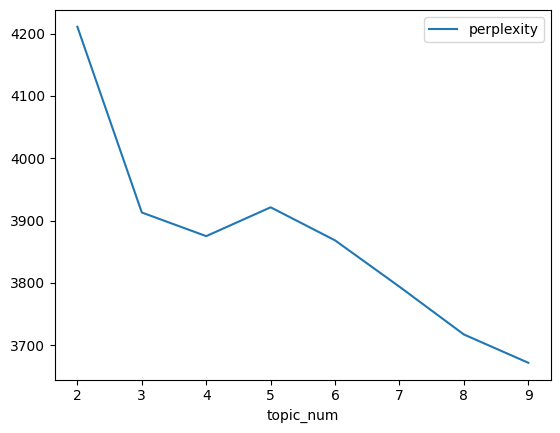

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='topic_num'>

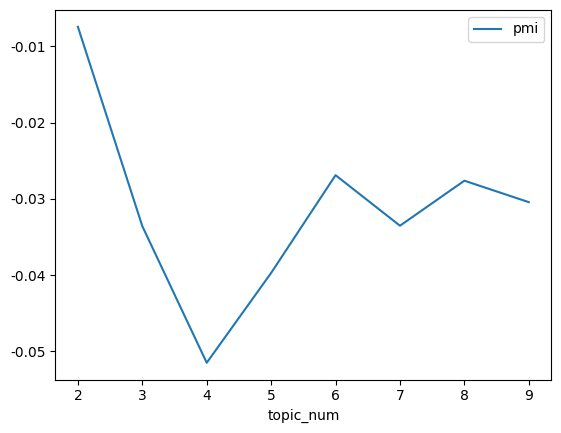

In [ ]:
result.plot.line(x='topic_num', y='pmi')

從perplexity and PMI來看，最好的主題數是2 or 9，先以9來做視覺化呈現


# 視覺化呈現

In [ ]:
best_model = LdaMulticore(
    corpus = corpus,
    num_topics = 9 ,
    id2word=dictionary,
    workers=2,
    random_state = 1500,
    iterations=100,
    passes=10 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.068617  0.046307       1        1  20.716397
6      0.033398  0.114883       2        1  19.520492
1      0.084373 -0.092075       3        1  16.691723
5      0.106603 -0.188137       4        1   9.918074
2      0.048507  0.074445       5        1   9.338659
3      0.099612 -0.073368       6        1   7.796653
7     -0.101885  0.201948       7        1   7.409561
4      0.031924  0.034499       8        1   4.989253
0     -0.371149 -0.118502       9        1   3.619188, topic_info=     Term         Freq        Total Category  logprob  loglift
111    台灣  1681.000000  1681.000000  Default  30.0000  30.0000
404    具體   528.000000   528.000000  Default  29.0000  29.0000
1711  機器人   479.000000   479.000000  Default  28.0000  28.0000
3415   中國  1546.000000  1546.000000  Default  27.0000  27.0000
3642   晶片  2036.000000  2036.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
2357   收入    65.574578   309.330345   Topic9  -5.4252   1.7677
1367   行動    55.221112   257.574643   Topic9  -5.5971   1.7790
2300   回應    52.045714   196.613031   Topic9  -5.6563   1.9898
63     經驗    56.162039   450.813773   Topic9  -5.5802   1.2361
248    符合    52.202672   241.609090   Topic9  -5.6533   1.7867

[733 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2713      1  0.379467    一些
2713      2  0.356699    一些
2713      3  0.161274    一些
2713      4  0.009487    一些
2713      5  0.034152    一些
...     ...       ...   ...
5839      5  0.087329   黃仁勳
5839      6  0.030375   黃仁勳
5839      7  0.020883   黃仁勳
5839      8  0.263885   黃仁勳
748       7  0.966485  黨派籍貫

[2608 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 7, 2, 6, 3, 4, 8, 5, 1])

可以看到(1,2,5,8),(6,4,3)很相近，試試看跑5個主題

In [30]:
num_topics = 5
num_words = 10

manual_model = LdaMulticore(
    corpus = corpus,
    num_topics = 5 ,
    id2word=dictionary,
    workers=2,
    random_state = 1500,
    iterations=100,
    passes=10 # 訓練次數
    )

for i in range(num_topics):
    print(f"主題 {i + 1}:")
    topic_words = manual_model.show_topic(i, num_words)
    for word, prob in topic_words:
        print(f"{word}: {prob:.4f}")
    print("\n")

pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(manual_model, corpus, dictionary)
p

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


主題 1:
具體: 0.0189
省錢妙招: 0.0069
食衣住行育樂: 0.0069
疫情: 0.0049
務必: 0.0045
學習: 0.0043
導致: 0.0038
故事: 0.0038
狀況: 0.0038
百度: 0.0034


主題 2:
美國: 0.0106
中國: 0.0095
晶片: 0.0058
輝達: 0.0056
投資: 0.0056
半導體: 0.0052
台灣: 0.0051
股價: 0.0047
發布: 0.0046
台積電: 0.0045


主題 3:
員工: 0.0057
科技: 0.0052
技術: 0.0047
馬斯克: 0.0043
工程師: 0.0042
特斯拉: 0.0040
系統: 0.0034
人才: 0.0034
經驗: 0.0032
服務: 0.0031


主題 4:
晶片: 0.0099
技術: 0.0094
微軟: 0.0052
輝達: 0.0052
英特爾: 0.0049
系統: 0.0042
生成式: 0.0040
運算: 0.0040
設計: 0.0035
訓練: 0.0032


主題 5:
台灣: 0.0132
技術: 0.0078
蘋果: 0.0068
全球: 0.0064
機器人: 0.0059
企業: 0.0056
創新: 0.0052
合作: 0.0049
黃仁勳: 0.0044
計畫: 0.0040




PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.075742 -0.137761       1        1  35.689534
3     -0.095218 -0.011853       2        1  25.280922
2     -0.030861  0.108385       3        1  19.906399
4     -0.075378  0.055723       4        1  14.167744
0      0.277199 -0.014494       5        1   4.955401, topic_info=     Term         Freq        Total Category  logprob  loglift
404    具體   493.000000   493.000000  Default  30.0000  30.0000
111    台灣  1753.000000  1753.000000  Default  29.0000  29.0000
3415   中國  1558.000000  1558.000000  Default  28.0000  28.0000
2678   蘋果   692.000000   692.000000  Default  27.0000  27.0000
1711  機器人   495.000000   495.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
63     經驗    65.841069   450.673269   Topic5  -5.7354   1.0812
1367   行動    56.766478   254.338504   Topic5  -5.8837   1.5050
248    符合    52.678170   238.391749   Topic5  -5.9584   1.4950
466    接受    50.169530   219.916554   Topic5  -6.0072   1.5269
2300   回應    49.890709   191.259176   Topic5  -6.0128   1.6609

[450 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2713      1  0.348076   一些
2713      2  0.228845   一些
2713      3  0.380768   一些
2713      4  0.038461   一些
2713      5  0.003846   一些
...     ...       ...  ...
5839      1  0.087820  黃仁勳
5839      2  0.199931  黃仁勳
5839      3  0.227959  黃仁勳
5839      4  0.483946  黃仁勳
5839      5  0.001869  黃仁勳

[1243 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 5, 1])

主題數設為5後，主題群就有比較明顯<br>
主題一:美中半導體爭奪戰和投資動態:主要集中在美中之間的半導體和晶片競爭，以及相關的投資和市場動態。台灣和台積電在這個主題中也佔有重要地位<br>

主題二:晶片技術和相關公司:包括微軟、輝達和英特爾等公司的技術發展。生成式運算、系統設計和技術訓練也是這個主題的重要內容。<br>

主題三:科技公司的人才和技術:包括員工、工程師和技術專業人士的經驗和服務。馬斯克作為特斯拉的領導者，也成為討論的重點之一。<br>

主題四:台灣在全球科技創新中的角色: 包括與蘋果等公司的合作和技術發展。機器人技術、企業創新和黃仁勳的相關計畫也是討論的重點。<br>

主題五:生活省錢和疫情影響:與日常生活相關包括如何省錢、生活中的各個方面（食衣住行育樂），以及疫情對生活的影響。此外，學習和個人故事也是討論的重點。<br>

# GuidedLDA

In [20]:
!pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA
import guidedlda

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Cloning https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git to /tmp/pip-install-zkgu2s9u/guidedlda_e03a0325bc654053957417990ea7f316
  Running command git clone --filter=blob:none --quiet https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git /tmp/pip-install-zkgu2s9u/guidedlda_e03a0325bc654053957417990ea7f316
  Resolved https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git to commit 05c3bf2c18f9d126cc5170256f33e6c1fbc90052
  Preparing metadata (setup.py) ... done
  Created wheel for GuidedLDA: filename=guidedlda-2.0.0.dev31-cp310-cp310-linux_x86_64.whl size=2558689 sha256=27a7f9a245d491e61d25592bd80093a9c30d5f4c725df89aea7144fcbe4ee842
  Stored in directory: /tmp/pip-ephem-wheel-cache-c2h3_s8y/wheels/2e/d3/0d/45d6ae01da5e14302f3f8e8260a78d13db2e37d72bae36c0cd
Successfully built GuidedLDA


In [21]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


('一支', '三節', '上線', '中小企業', '互利', '借貸', '健康', '兒童', '公開', '共同')

In [22]:
word2id = dictionary.token2id

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
word2id

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'一支': 0,
 '三節': 1,
 '上線': 2,
 '中小企業': 3,
 '互利': 4,
 '借貸': 5,
 '健康': 6,
 '兒童': 7,
 '公開': 8,
 '共同': 9,
 '分析': 10,
 '創作': 11,
 '創新': 12,
 '創立': 13,
 '加入': 14,
 '加分': 15,
 '區塊鏈技術': 16,
 '協助': 17,
 '台大': 18,
 '合作': 19,
 '國內外': 20,
 '國際': 21,
 '圖文': 22,
 '地點台北市': 23,
 '執行': 24,
 '基金會': 25,
 '多年': 26,
 '夢想': 27,
 '大使': 28,
 '媒合': 29,
 '媒體': 30,
 '實習': 31,
 '專業': 32,
 '山區': 33,
 '年輕人': 34,
 '影音': 35,
 '徵求': 36,
 '投資': 37,
 '投遞履歷': 38,
 '指導': 39,
 '提案': 40,
 '撰寫': 41,
 '操作': 42,
 '擔任': 43,
 '最具': 44,
 '服務': 45,
 '汽車': 46,
 '溫度': 47,
 '熟悉': 48,
 '獨角獸': 49,
 '產品設計': 50,
 '社會': 51,
 '社群': 52,
 '福利': 53,
 '科技': 54,
 '科技趨勢': 55,
 '科系': 56,
 '移動': 57,
 '立志': 58,
 '策略': 59,
 '紀律': 60,
 '組成': 61,
 '經營': 62,
 '經驗': 63,
 '績效': 64,
 '聯合': 65,
 '聯盟': 66,
 '職缺': 67,
 '興趣': 68,
 '舉辦': 69,
 '舞台': 70,
 '蒐集': 71,
 '薪資待遇': 72,
 '融資': 73,
 '行銷': 74,
 '行銷活動': 75,
 '議題': 76,
 '資源': 77,
 '軟體': 78,
 '透明': 79,
 '速度': 80,
 '連絡': 81,
 '邀請': 82,
 '邁向': 83,
 '金融': 84,
 '金融服務': 85,
 '金融科技': 86,
 '開創': 87,
 '關注': 88,
 '額外'

In [24]:
seed_topic_list = [
  ["晶片","半導體","輝達","硬體","台積電","美國","台灣","中國","伺服器","技術","製程","營收","運算","黃仁勳"],
  ["機器人","微軟","投資","馬斯克","股價","生成式","人類","智慧","特斯拉","合作","股市","創新","輝達","黃仁勳"],
  ["職場","學習","專利","大學","就業","工程師","助理","報名","履歷","計畫","經驗","應徵","通知","經歷","食衣住行育樂","職缺"],
  ["區塊鏈","虛擬世界","沉浸式體驗","擴增實境","虛擬實境","加密貨幣","元宇宙"],
  ["疫情","經濟衰退","人工智能","自動化","科技創新","人力資源","市場需求","企業文化","科技公司","兼差","省錢妙招","蘋果","職缺"]
]
# 硬體
# AI機器人
# AI相關工作
# 元宇宙
# 疫情後裁員


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
# 確認有seed_topic的字詞有在dictionary裡
# Initialize an empty list to store missing words
missing_words = []

# Iterate through the seed_topic_list
for topic in seed_topic_list:
    for word in topic:
        # Check if the word is not in the dictionary
        if word not in word2id:
            missing_words.append(word)

# Print the list of missing words
print("Missing words:", missing_words)

Missing words: []


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))


doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 0: 晶片 中國 美國 台灣 半導體 台積電 英特爾 輝達 全球 技術
Topic 1: 輝達 微軟 蘋果 黃仁勳 一些 人類 正在 投資 機器人 員工
Topic 2: 具體 經驗 大學 學習 面試 工程師 薪資 計畫 職缺 食衣住行育樂
Topic 3: 技術 系統 服務 企業 元宇宙 設計 運算 軟體 創新 功能
Topic 4: 股價 分析師 伺服器 股票 增長 營收 發布 指數 增加 投資
Topic 5: 成長 台股 需求 營收 帶動 發布 看好 全球 智慧 廣達


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.011631  0.111640       1        1  23.641007
3      0.054235 -0.194480       2        1  20.537779
0     -0.101756 -0.234658       3        1  18.227230
5     -0.186416  0.032781       4        1  15.303508
4     -0.151026  0.218956       5        1  11.750716
2      0.373331  0.065760       6        1  10.539760, topic_info=     Term         Freq        Total Category  logprob  loglift
3642   晶片  2061.000000  2061.000000  Default  30.0000  30.0000
3415   中國  1572.000000  1572.000000  Default  29.0000  29.0000
1941  半導體  1233.000000  1233.000000  Default  28.0000  28.0000
1179   美國  2033.000000  2033.000000  Default  27.0000  27.0000
593    技術  2248.000000  2248.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
530    計畫   173.626066   634.066183   Topic6  -5.5204   0.9548
98     人才   156.663574   490.279925   Topic6  -5.6232   1.1091
582    員工   154.667987   639.127797   Topic6  -5.6360   0.8312
1024   狀況   121.740798   238.598801   Topic6  -5.8754   1.5771
10     分析   136.707702   593.068831   Topic6  -5.7595   0.7826

[436 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2713      1  0.920679    一些
2713      5  0.063624    一些
2713      6  0.014970    一些
5297      5  1.001013   一季度
1797      1  0.870066    一家
...     ...       ...   ...
4755      5  1.001660    高盛
7764      3  1.000775   魏哲家
5935      4  0.998315    鴻海
5937      4  1.000792  鴻海集團
5839      1  0.999206   黃仁勳

[756 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 6, 5, 3])

經過GuidedLDA後的主題描述可以看出，主要討論的焦點包括：<br>
1. 科技公司及其領導人的動態:圍繞著一些大型科技公司如輝達、微軟和蘋果，並提到這些公司的領導人如黃仁勳，以及他們在投資、機器人技術和員工管理方面的動態。<br>
2. 技術創新與應用:主要討論技術創新及其在企業中的應用，包括系統設計、運算技術、軟體服務和元宇宙等新興技術。<br>
3. 半導體產業及其地緣政治影響:討論半導體產業，特別是涉及到台積電、英特爾等主要公司，以及中國、美國、台灣在全球半導體市場中的角色和技術競爭。<br>
4. 市場需求與公司成長:涉及市場需求的變化及其對公司成長的影響，特別是台股市場的動態、公司的營收增長和全球市場的前景。<br>
5. 股票市場與財務分析:圍繞股票市場，特別是科技公司的股價、分析師的意見、伺服器市場的增長、營收數據和投資動態。<br>
6. 教育與職業發展:這個主題主要涉及教育和職業發展，特別是工程師職位的面試經驗、薪資水平以及相關的學習和職業計畫。<br>

# LDA主題分佈

In [31]:
# 取得每條新聞的主題分佈
topics_doc = manual_model.get_document_topics(corpus)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
topics_doc[100]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.99910736)]

In [33]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0.        , 0.        , 0.93856311, 0.        , 0.05616001],
       [0.        , 0.04208757, 0.        , 0.        , 0.95419073],
       [0.        , 0.        , 0.99208933, 0.        , 0.        ],
       ...,
       [0.        , 0.48948294, 0.03587919, 0.        , 0.47166115],
       [0.        , 0.        , 0.        , 0.9960351 , 0.        ],
       [0.        , 0.        , 0.        , 0.99741501, 0.        ]])

In [34]:
df['topic_label'] = m_theta.argmax(axis=1) + 1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
df['topic_label'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_label
2    870
4    504
3    472
5    288
1     38
Name: count, dtype: int64

In [36]:
df.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,artUrl,artCatagory,artDate,words,topic_label
0,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,Finance,2022-02-15 17:29:30,"[實習, 普匯, 金融科技, 職缺, 徵求, 商管, 科系, 關注, 時事, 議題, 國內外...",3
1,中央社記者張璦台北日電台灣銀行消金企金政府部門業務三駕馬車再發威董事長呂桔誠今天表示台銀今年...,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,Finance,2022-05-21 02:29:23,"[中央社, 張璦, 台北日電, 台灣, 銀行, 消金, 企金, 政府部門, 業務, 三駕, ...",5
2,記者陳美君台北報導年月日週二上午擁抱金飯碗的機會來了中央銀行近日公開徵才開出的職缺包括經濟金...,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,Finance,2023-02-14 11:45:19,"[美君, 台北, 週二, 金飯碗, 中央銀行, 近日, 公開, 徵才, 開出, 職缺, 經濟...",3
3,證交所徵才開創數位驅動時代報名至止中央社年月日週一下午中央社記者潘智義台北年月日電台灣證券交...,https://www.ptt.cc/bbs/Finance/M.1698684536.A....,Finance,2023-10-31 00:48:54,"[證交所, 徵才, 開創, 數位, 時代, 報名, 中央社, 中央社, 潘智義, 台北, 日...",5
4,版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同意一切遵循現行法律並確...,https://www.ptt.cc/bbs/job/M.1641165773.A.E67....,job,2022-01-03 07:22:51,"[禁止張貼, 違反就業, 服務, 性別平等, 勞基法, 文章發文者, 同意, 遵循, 確知文...",3


In [37]:
df['artDate'] = pd.to_datetime(df['artDate'])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
df['artDate'].dt.date

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       2022-02-15
1       2022-05-21
2       2023-02-14
3       2023-10-31
4       2022-01-03
           ...    
2167    2024-05-29
2168    2024-05-29
2169    2024-05-29
2170    2024-05-31
2171    2024-05-31
Name: artDate, Length: 2172, dtype: object

In [39]:
df.groupby(df['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


artDate     topic_label
2022-01-03  4              0.500000
            3              0.500000
2022-01-04  3              0.500000
            2              0.250000
            5              0.250000
                             ...   
2024-05-30  3              0.100000
2024-05-31  4              0.444444
            2              0.222222
            5              0.222222
            3              0.111111
Name: proportion, Length: 1380, dtype: float64

In [40]:
date_topic = df.groupby(df['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_label,1,2,3,4,5
artDate,,,,,
2022-01-03,NaN,NaN,0.5,0.5,NaN
2022-01-04,NaN,0.25,0.5,NaN,0.25
2022-01-05,NaN,NaN,0.5,0.5,NaN
2022-01-06,NaN,0.20,0.4,0.2,0.20
2022-01-07,NaN,NaN,NaN,1.0,NaN


資料太多不好做視覺化，所以取每個月的平均值

In [71]:
# 按日期分組並計算每個主題標籤的相對頻率
retrieve_date_topic = df.groupby(df['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
# 將日期設置為索引
retrieve_date_topic.index = pd.to_datetime(retrieve_date_topic.index)
retrieve_date_topic=retrieve_date_topic.fillna(0)
retrieve_date_topic.sort_values(by='artDate', ascending=True)
# 重新取樣數據，按月取樣並獲取每個月的平均值
monthly_mean = retrieve_date_topic.resample('MS').mean()
# 顯示前幾行
monthly_mean.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_label,1,2,3,4,5
artDate,,,,,
2022-01-01,0.000000,0.150000,0.593478,0.175362,0.081159
2022-02-01,0.000000,0.315909,0.487879,0.158333,0.037879
2022-03-01,0.025641,0.195513,0.278846,0.333333,0.166667
2022-04-01,0.178571,0.182540,0.392857,0.206349,0.039683
2022-05-01,0.020000,0.103333,0.480000,0.200000,0.196667


In [72]:
monthly_mean.index = monthly_mean.index.strftime('%Y-%m')
monthly_mean.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_label,1,2,3,4,5
artDate,,,,,
2022-01,0.000000,0.150000,0.593478,0.175362,0.081159
2022-02,0.000000,0.315909,0.487879,0.158333,0.037879
2022-03,0.025641,0.195513,0.278846,0.333333,0.166667
2022-04,0.178571,0.182540,0.392857,0.206349,0.039683
2022-05,0.020000,0.103333,0.480000,0.200000,0.196667


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


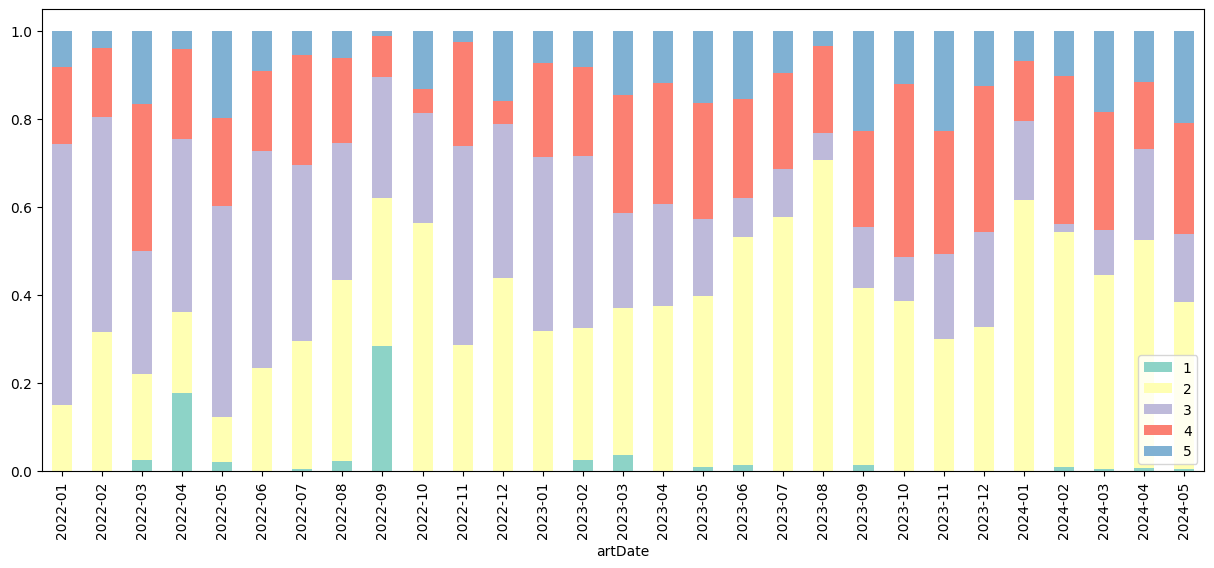

In [73]:
fig, ax = plt.subplots(figsize=(15, 6))
monthly_mean.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

主題一:美中半導體爭奪戰和投資動態<br>

主題二:晶片技術和相關公司<br>

主題三:科技公司的人才和技術<br>

主題四:台灣在全球科技創新中的角色<br>

主題五:生活省錢和疫情影響<br>

1. 美中半導體爭奪戰和投資動態
  - 趨勢: 在2022年4月和2022年9月的關注量相較其他時間線較高。
  - 原因: 可能受到國際局勢變化和政策影響，特別是美中貿易戰和相關投資政策的變動。
  - 2022年8月美國《晶片與科學法案》生效，確保在本土建置半導體製造產能與投入先進半導體技術研發，隨即在2022年提出一連串針對中國大陸半導體產業的出口管制措施，擴大限制範圍，降低中國大陸對美國及全球半導體產業的競爭威脅。
2. 晶片技術和相關公司
  - 趨勢: 該主題在2022年中期到2024年都有大量的討論，關注度持續高漲。
  - 原因: 全球半導體供應議題和台灣有重大的聯繫，尤其在GPT出現後，硬體設備和GPU的算力都和台灣息息相關。
3. 科技公司的人才和技術
  - 趨勢: 這個主題的關注度在2022年一直很高，但在2023年後關注量下降很多。
  - 原因: 科技公司的人才競爭和技術創新是持續關注的焦點，特別是在疫情期間，遠程工作和技術需求增加。然而，隨著疫情狀況改善，市場需求和關注度有所回落。
4. 台灣在全球科技創新中的角色
  - 趨勢: 該主題在2023,2024年的關注度有上升
  - 原因: 全球半導體供應議題和台灣有重大的聯繫，尤其在GPT出現後，硬體設備和GPU的算力都和台灣息息相關。
5. 生活省錢和疫情影響
  - 趨勢: 這個主題的關注量一直都不高且相對穩定。
  - 原因: 疫情已趨近穩定控制

總結:
- 主題二和主題四在2023, 2024年的關注度都節節攀升，說明ChatGPT發布後晶片技術和硬體設備的討論度都隨之上升，連帶影響台灣的新科技發展趨勢。
- 主題三和主題五在2022年末後，討論聲度都有下降，說明疫情的影響也漸漸消退。

# GuidedLDA主題分佈

In [19]:
guided_df=df.copy()
guided_df.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,artUrl,artCatagory,artDate,words
0,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,Finance,2022-02-15 17:29:30,"[實習, 普匯, 金融科技, 職缺, 徵求, 商管, 科系, 關注, 時事, 議題, 國內外..."
1,中央社記者張璦台北日電台灣銀行消金企金政府部門業務三駕馬車再發威董事長呂桔誠今天表示台銀今年...,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,Finance,2022-05-21 02:29:23,"[中央社, 張璦, 台北日電, 台灣, 銀行, 消金, 企金, 政府部門, 業務, 三駕, ..."
2,記者陳美君台北報導年月日週二上午擁抱金飯碗的機會來了中央銀行近日公開徵才開出的職缺包括經濟金...,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,Finance,2023-02-14 11:45:19,"[美君, 台北, 週二, 金飯碗, 中央銀行, 近日, 公開, 徵才, 開出, 職缺, 經濟..."


In [63]:
# 獲取每篇文章的主題分布
doc_topic = model.doc_topic_
doc_topic[100]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([1.11227282e-05, 1.11227282e-05, 9.99944386e-01, 1.11227282e-05,
       1.11227282e-05, 1.11227282e-05])

In [64]:
guided_df['topic_label'] = doc_topic.argmax(axis=1) + 1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
guided_df['topic_label'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_label
2    503
6    429
1    406
4    366
5    254
3    214
Name: count, dtype: int64

In [66]:
guided_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,artUrl,artCatagory,artDate,words,topic_label
0,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,Finance,2022-02-15 17:29:30,"[實習, 普匯, 金融科技, 職缺, 徵求, 商管, 科系, 關注, 時事, 議題, 國內外...",4
1,中央社記者張璦台北日電台灣銀行消金企金政府部門業務三駕馬車再發威董事長呂桔誠今天表示台銀今年...,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,Finance,2022-05-21 02:29:23,"[中央社, 張璦, 台北日電, 台灣, 銀行, 消金, 企金, 政府部門, 業務, 三駕, ...",4
2,記者陳美君台北報導年月日週二上午擁抱金飯碗的機會來了中央銀行近日公開徵才開出的職缺包括經濟金...,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,Finance,2023-02-14 11:45:19,"[美君, 台北, 週二, 金飯碗, 中央銀行, 近日, 公開, 徵才, 開出, 職缺, 經濟...",3
3,證交所徵才開創數位驅動時代報名至止中央社年月日週一下午中央社記者潘智義台北年月日電台灣證券交...,https://www.ptt.cc/bbs/Finance/M.1698684536.A....,Finance,2023-10-31 00:48:54,"[證交所, 徵才, 開創, 數位, 時代, 報名, 中央社, 中央社, 潘智義, 台北, 日...",4
4,版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同意一切遵循現行法律並確...,https://www.ptt.cc/bbs/job/M.1641165773.A.E67....,job,2022-01-03 07:22:51,"[禁止張貼, 違反就業, 服務, 性別平等, 勞基法, 文章發文者, 同意, 遵循, 確知文...",3


In [74]:
guided_df['artDate'] = pd.to_datetime(guided_df['artDate'])
guided_df.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,artUrl,artCatagory,artDate,words,topic_label
0,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,Finance,2022-02-15 17:29:30,"[實習, 普匯, 金融科技, 職缺, 徵求, 商管, 科系, 關注, 時事, 議題, 國內外...",4
1,中央社記者張璦台北日電台灣銀行消金企金政府部門業務三駕馬車再發威董事長呂桔誠今天表示台銀今年...,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,Finance,2022-05-21 02:29:23,"[中央社, 張璦, 台北日電, 台灣, 銀行, 消金, 企金, 政府部門, 業務, 三駕, ...",4
2,記者陳美君台北報導年月日週二上午擁抱金飯碗的機會來了中央銀行近日公開徵才開出的職缺包括經濟金...,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,Finance,2023-02-14 11:45:19,"[美君, 台北, 週二, 金飯碗, 中央銀行, 近日, 公開, 徵才, 開出, 職缺, 經濟...",3


In [75]:
# 按日期分組並計算每個主題標籤的相對頻率
guided_retrieve_date_topic = guided_df.groupby(df['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
# 將日期設置為索引
guided_retrieve_date_topic.index = pd.to_datetime(guided_retrieve_date_topic.index)
guided_retrieve_date_topic=guided_retrieve_date_topic.fillna(0)
guided_retrieve_date_topic.sort_values(by='artDate', ascending=True)
# 重新取樣數據，按月取樣並獲取每個月的平均值
guided_monthly_mean = guided_retrieve_date_topic.resample('MS').mean()
# 顯示前幾行
guided_monthly_mean.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_label,1,2,3,4,5,6
artDate,,,,,,
2022-01-01,0.168116,0.135507,0.287681,0.233333,0.000000,0.175362
2022-02-01,0.106061,0.140909,0.299242,0.169697,0.106061,0.178030
2022-03-01,0.105769,0.217949,0.243590,0.310897,0.019231,0.102564
2022-04-01,0.047619,0.107143,0.452381,0.242063,0.047619,0.103175
2022-05-01,0.120000,0.196667,0.230000,0.270000,0.033333,0.150000


In [76]:
guided_monthly_mean.index = guided_monthly_mean.index.strftime('%Y-%m')
guided_monthly_mean.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_label,1,2,3,4,5,6
artDate,,,,,,
2022-01,0.168116,0.135507,0.287681,0.233333,0.000000,0.175362
2022-02,0.106061,0.140909,0.299242,0.169697,0.106061,0.178030
2022-03,0.105769,0.217949,0.243590,0.310897,0.019231,0.102564
2022-04,0.047619,0.107143,0.452381,0.242063,0.047619,0.103175
2022-05,0.120000,0.196667,0.230000,0.270000,0.033333,0.150000


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


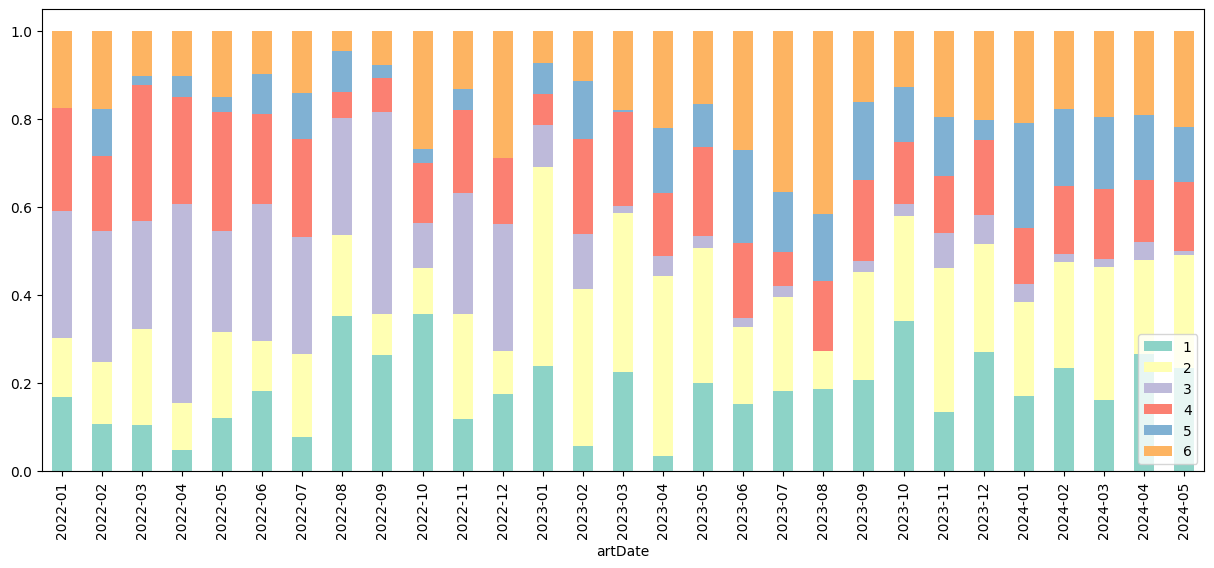

In [77]:
fig, ax = plt.subplots(figsize=(15, 6))
guided_monthly_mean.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

1. 科技公司及其領導人的動態<br>
2. 技術創新與應用<br>
3. 半導體產業及其地緣政治影響<br>
4. 市場需求與公司成長<br>
5. 股票市場與財務分析<br>
6. 教育與職業發展<br>

1. 科技公司及其領導人的動態
  - 在2022年8月、10月和2023年10月達到高峰，這可能是由於科技公司在這些月份進行了大量的高層變動和戰略調整，以及領導人動態的重大新聞事件。<br>
  - 例如微軟（Microsoft）宣布新的CEO上任、Meta（前Facebook）在全球範圍內裁員，影響了數千名員工。<br>

2. 技術創新與應用
  - 在2023年和2024年的討論度大幅上升，可能是由於新的技術突破和應用在這段期間內被廣泛報導和討論。
  - 例如多項技術突破在消費電子展（CES）上發布，包括新型AI技術和量子計算應用。<br>

3. 半導體產業及其地緣政治影響
  - 在2023年後大幅下降討論度，推論是因為機率被平均時，被主題一和二搶走討論度。

4. 市場需求與公司成長
  - 從2022年到2024年慢慢下降，可能是因為市場需求和公司成長的報導受到其他更具吸引力的新聞主題的影響。<br>

5. 股票市場與財務分析
  - 在2023年後快速升高，推斷是AI相關的股票在GPT出現後不斷被討論。<br>

6. 教育與職業發展
  - 在2023年後快速升高，推斷是AI工作需求急速攀升。<br>
